In [21]:
# PARTIE LECTURE CSV ET MISE EN PLACE INFOS DANS UN CSV PROPRE

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pandas as pd
import numpy as np
import os
import time
import os.path
from icalendar import Calendar
import csv
import datetime
from datetime import datetime 
import sys
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

class Infos():
    bn = "Reseau Bayesien"
    
    infos = "Informations"

Infos = Infos()

# ****************************** PARTIE CONSTRUCTION DU RESEAU ********************************
  
def bn_creation(agenda_file):
    # ======== PARTIE LECTURE DU CSV ===========
    df = pd.read_csv("agenda.csv",sep = '\t')

    # Le fichier CSV doit être de la forme :
    """FORMAT AGENDA :
    JOUR         HEURE         ACTIVITE
    ...          ...           ...
    ...          ...           ...
    """

    # ======== PARTIE CREATION DES VARIABLES =========
    # Variables créées à partir du csv
    Actis = df['ACTIVITE'].unique() #Actis = ['Maison','Travail','Repas','Sport','Ecole','Golf','Plancha','Promenade','Rien']
    c = gum.LabelizedVariable("calendar","User Calendar",Actis)

    #Jours = df['JOUR'].unique() #['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche']
    #Heures = df['HEURE'].unique().astype(str) #['7','8','9','10','11','12','13','14','15','16','17','18','19','20']

    # Variables fixes
    d = gum.LabelizedVariable("day","Day of the week",['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    h = gum.LabelizedVariable("hour","Hour of the day",['7','8','9','10','11','12','13','14','15','16','17','18','19','20'])

    # Informations reçues par le broker
    pA = gum.LabelizedVariable("phoneActivity","Phone's mvt",['no activity','low activity','high activity'])
    pL = gum.LabelizedVariable("phoneLoc","Phone's localisation",['maison','travail','cantine','sport','ecole','golf','maisonAmis','inconnue'])
    wA = gum.LabelizedVariable("watchActivity","Watch's mvt",['no activity','low activity','high activity'])
    wL = gum.LabelizedVariable("watchLoc","Watch's localisation",['maison','travail','cantine','sport','ecole','golf','maisonAmis','inconnue'])

    pcR = gum.LabelizedVariable("phoneContextReliability","Reliability of the phone information",['phoneReliability','phoneNotReliable'])
    wcR = gum.LabelizedVariable("watchContextReliability","Reliability of the watch information",['watchReliability','watchNotReliable'])

    # ========= PARTIE CREATION BN ===========
    bn = gum.BayesNet('ContextInfoReliability')
    day = bn.add(d)
    hour = bn.add(h)
    calendar = bn.add(c)
    pActi = bn.add(pA)
    pLoc = bn.add(pL)
    wActi = bn.add(wA)
    wLoc = bn.add(wL)
    phoneContextReliability = bn.add(pcR)
    watchContextReliability = bn.add(wcR)

    # ======= CREATION DES LIENS DU BN ===========
    bn.addArc(hour,calendar)
    bn.addArc(day,calendar)
    bn.addArc(calendar,phoneContextReliability)
    bn.addArc(pActi,phoneContextReliability)
    bn.addArc(wActi,phoneContextReliability)
    bn.addArc(pLoc,phoneContextReliability)
    bn.addArc(wLoc,phoneContextReliability)
    bn.addArc(calendar,watchContextReliability)
    bn.addArc(pActi,watchContextReliability)
    bn.addArc(wActi,watchContextReliability)
    bn.addArc(pLoc,watchContextReliability)
    bn.addArc(wLoc,watchContextReliability)


    # ======= REMPLISSAGE DES PROBAS ==========
    # Probas toujours identiques car répartitions égales qui ne changent jamais
    bn.cpt(day)[:]=[0.1429,0.1428,0.1429,0.1428,0.1429,0.1428,0.1429]
    bn.cpt(hour)[:]=[0.07,0.07,0.07,0.07,0.07,0.08,0.08,0.07,0.07,0.07,0.07,0.07,0.07,0.07]

    # Remplissage des probas du calendrier
    for i in range(0,len(df)):
        if df.iloc[i,2] == Actis[len(Actis)-1]:
            bn.cpt(calendar)[df.iloc[i,0],str(df.iloc[i,1]),:] = [0.14,0.01,0.14,0.14,0.01,0.14,0.14,0.14,0.14]
        else :
            for k in range(0,len(Actis)-1):
                tab = np.zeros(len(Actis)) + 0.00625
                if df.iloc[i,2] == Actis[k]:
                    tab[k] = 0.95;
                    bn.cpt(calendar)[df.iloc[i,0],str(df.iloc[i,1]),:] = tab

    # Remplissage des probas générales
    df['count'] = 1
    df2 = df.groupby(['ACTIVITE'],sort=False).count()['count']
    tot = df2.sum()
    tab  = np.zeros(len(pL.labels()))
    for i in range(0,len(df2)):
        if i == len(df2)-1:
            tab[i-1] = tab[i-1] + df2.iloc[i]/tot
        else :
            tab[i] = df2.iloc[i]/tot

    bn.cpt(pLoc)[:] = tab
    bn.cpt(wLoc)[:] = tab
    bn.cpt(pActi)[:] = [0.4,0.4,0.2]
    bn.cpt(wActi)[:] = [0.4,0.4,0.2]

    # Remplissage des probas de contextReliability

    for i in range(0,len(c.labels())):
        for k in range(0,len(pA.labels())):
            for j in range (0,len(pL.labels())):
                for g in range(0,len(wA.labels())):
                    for h in range (0,len(wL.labels())):
                        bn.cpt(phoneContextReliability)[wL.label(h),pL.label(j),wA.label(g),pA.label(k),c.label(i),:]=[0.05,0.95]
                        bn.cpt(watchContextReliability)[wL.label(h),pL.label(j),wA.label(g),pA.label(k),c.label(i),:]=[0.05,0.95]

    for i in range(0,len(c.labels())):
        for k in range(0,len(pA.labels())):
            for j in range (0,len(pL.labels())):
                for l in range (0,len(wL.labels())):
                    for h in range(0,len(wA.labels())):
                        if j == l : # Si la montre et le smartphone ont la même localisation
                            if k == h : # Si la montre et le smartphone ont la même activité
                                if j == i or (i == len(c.labels())-1 and j == len(pL.labels())-1):  # Si les positions correspondent au calendrier
                                    bn.cpt(phoneContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.95,0.05]
                                    bn.cpt(watchContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.95,0.05]
                                else : 
                                    bn.cpt(phoneContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.80,0.20]
                                    bn.cpt(watchContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.80,0.20]
                            else :
                                if j == i or (i == len(c.labels())-1 and j == len(pL.labels())-1):  # Si les positions correspondent au calendrier
                                    bn.cpt(phoneContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.88,0.12]
                                    bn.cpt(watchContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.88,0.12]
                                else :
                                    bn.cpt(phoneContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.50,0.50]
                                    bn.cpt(watchContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.50,0.50]
                        else : 
                            if k == h : # Si la montre et le smartphone ont la même activité
                                if j == i or (i == len(c.labels())-1 and j == len(pL.labels())-1):  # Si la position du telephone correspond au calendrier
                                    bn.cpt(phoneContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.60,0.40]
                                    bn.cpt(watchContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.20,0.80]
                                elif l == i or (i == len(c.labels())-1 and l == len(wL.labels())-1): # Si la position de la montre correspond au calendrier
                                    bn.cpt(phoneContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.20,0.80]
                                    bn.cpt(watchContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.60,0.40]
                                else :
                                    bn.cpt(phoneContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.10,0.90]
                                    bn.cpt(watchContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.10,0.90]
                            else :
                                if j == i or (i == len(c.labels())-1 and j == len(pL.labels())-1):  # Si la position du telephone correspond au calendrier
                                    bn.cpt(phoneContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.55,0.45]
                                    bn.cpt(watchContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.10,0.90]
                                elif l == i or (i == len(c.labels())-1 and l == len(wL.labels())-1): # Si la position de la montre correspond au calendrier
                                    bn.cpt(phoneContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.10,0.90]
                                    bn.cpt(watchContextReliability)[wL.label(l),pL.label(j),wA.label(h),pA.label(k),c.label(i),:]=[0.55,0.45]

    Infos.bn = bn

# ****************************** PARTIE LECTURE DATA ********************************

def actu_infos(smart_data,watch_data,day,hour):
    # ======= LECTURE DU CSV =========
    df1 = pd.read_csv(smart_data,sep = '\t')
    df2 = pd.read_csv(watch_data,sep = '\t')
    phoneLoc = df1.iloc[0,0]
    phoneActivity = df2.iloc[0,1]
    watchLoc = df1.iloc[0,0]
    watchActivity = df2.iloc[0,1]
    # infos = [day,hour,phoneLoc,watchLoc,phoneActivity,watchActivity]
    infos = [day,hour,phoneLoc,watchLoc,phoneActivity,watchActivity]
    Infos.infos = infos
    
# ******************************* PARTIE ISC2CSV **********************************
def ics2csv(filename):
    file_extension = str(filename)[-3:]
    headers = ('JOUR','HEURE','ACTIVITE')
    if os.path.isfile(filename):
        if file_extension == 'ics':
            # Creation of the CSV file
            csvfile = filename[:-3] + "csv"
            myfile = open(csvfile,'w')
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerow(headers)
            
            # Openning the ICS file to gather informations
            f = open(filename, 'rb')
            cal = Calendar.from_ical(f.read())
            
            for component in cal.walk():
                if component.get('DTSTART') != None and component.get('DTEND') != None:
                    
                    # Day finding
                    start = str(component.get('DTSTART').dt)
                    end = str(component.get('DTEND').dt)
                    day = datetime.date(int(start[:4]), int(start[5:7]), int(start[8:10])).weekday()
                    jour = None
                    if day == 0: jour = "Monday"
                    if day == 1: jour = "Tuesday"
                    if day == 2: jour = "Wednesday"
                    if day == 3: jour = "Thursday"
                    if day == 4: jour = "Friday"
                    if day == 5: jour = "Saturday"
                    if day == 6: jour = "Sunday"
                        
                    # Completing the CSV with day, activity and hours    
                    if start[11:13] != '' and end[11:13] != '':
                        for i in range(int(start[11:13]),int(end[11:13])):
                            values = (jour, i, component.get('SUMMARY'))
                            wr.writerow(values)
            f.close()
            myfile.close()
        else:
            print("You entered ", filename, ". ")
            print(file_extension.upper(), " is not a valid file format. Looking for an ICS file.")
            exit(0)
    else:
        print("I can't find the file ", filename, ".")
        print("Please enter an ics file located in the same folder as this script.")
        exit(0)

# ***************************** PARTIE WATCHDOG ***********************************
class MonitorFolder(FileSystemEventHandler):
    FILE_SIZE=1000
   
    def on_modified(self, event):
        if event.src_path == "./agenda.csv":
            bn_creation("./agenda.csv")
        elif event.src_path == "./phoneInfos.csv" or event.src_path == "./watchInfos.csv":
            hour = datetime.now().strftime("%H")
            day = datetime.today().strftime('%A')
            actu_infos("./phoneInfos.csv","./watchInfos.csv",day,hour)
            gnb.showInference(Infos.bn,size="10",evs={'day':Infos.infos[0],'hour':Infos.infos[1], 'phoneLoc':Infos.infos[2],'watchLoc':Infos.infos[3],'phoneActivity':Infos.infos[4],'watchActivity':Infos.infos[5]})
        elif event.src_path == "./agenda.ics":
            ics2csv("pfarey.ics")
            
# ***************************** PARTIE RUN ****************************************
bn_creation("agenda.csv")
#actu_infos("phoneInfos.csv","watchInfos.csv")
              
if __name__ == "__main__":
    src_path = "./"
    
    event_handler=MonitorFolder()
    observer = Observer()
    observer.schedule(event_handler, path=src_path, recursive=True)
    print("Monitoring started")
    observer.start()
    try:
        while(True):
            time.sleep(1)
           
    except KeyboardInterrupt:
            observer.stop()
            observer.join()
#gnb.showInference(bn,size="10",evs={'day':infos[0],'hour':infos[1], phoneLoc':infos[2],'watchLoc':infos[3],'phoneActivity':infos[4],'watchActivity':infos[5]})


Monitoring started


Exception in thread Thread-26:
Traceback (most recent call last):
  File "C:\Users\pablo\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\pablo\anaconda3\lib\site-packages\watchdog\observers\api.py", line 203, in run
    self.dispatch_events(self.event_queue, self.timeout)
  File "C:\Users\pablo\anaconda3\lib\site-packages\watchdog\observers\api.py", line 376, in dispatch_events
    handler.dispatch(event)
  File "C:\Users\pablo\anaconda3\lib\site-packages\watchdog\events.py", line 331, in dispatch
    {
  File "<ipython-input-21-9754bb342984>", line 244, in on_modified
  File "C:\Users\pablo\anaconda3\lib\site-packages\pyAgrum\lib\notebook.py", line 770, in showInference
    grinf = _get_showInference(model, engine, evs, targets, size, nodeColor, arcWidth, arcColor, cmap, cmapArc, graph,
  File "C:\Users\pablo\anaconda3\lib\site-packages\pyAgrum\lib\notebook.py", line 719, in _get_showInference
    return BNinference2dot(model, size, engine, e

In [11]:
Infos.infos

['Tuesday', '21', 'maison', 'maison', 'no activity', 'no activity']

In [26]:
hour = datetime.now().strftime("%H")
day = datetime.today().strftime('%A')

type(hour)

str

In [48]:
vc=gum.LabelizedVariable("c","c",['X','Y','Z'])
print(vc)

c<X,Y,Z>


In [6]:
coucou = 'maison'
coucou

'maison'

In [4]:
bn

(gum::BayesNet<double>@0x2e77e7699a0) BN{nodes: 8, arcs: 7, domainSize: 10^6.18301, dim: 16477}

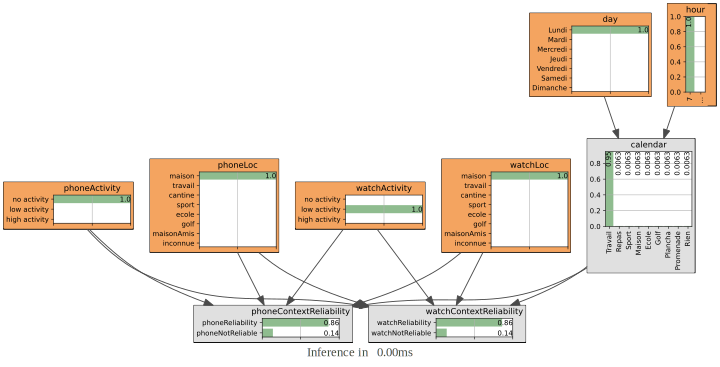

In [20]:
gnb.showInference(Infos.bn,size="10",evs={'day':'Lundi','hour':'7','phoneLoc':'maison','watchLoc':'maison','phoneActivity':'no activity','watchActivity':'low activity'})

In [2]:
0.005*9 + 0.955

1.0